In [1]:
import numpy as np
# Relational Q-learning
# applying Q-learning in r-space
actions = ['move-up', 'move-down', 'move-left', 'move-right', 'move-up-right',
    'move-up-left', 'move-down-right', 'move-down-left', 'pick-up', 'put-down']

move_actions = actions[0:8]

r_actions = ['go-to-ball', 'go-to-box', 'pick-up-ball', 'pick-up-box',
    'put-down-ball', 'put-down-box']

In [2]:
def move(position, move_action):
    """
    Returns a new position after a move in some direction
    """
    x, y = position.values()
    if move_action in ['move-up', 'move-up-right', 'move-up-left']:
        x -= 1 # Moves up
    elif move_action in ['move-down', 'move-down-right', 'move-down-left']:
        x += 1 # Moves down
    if move_action in ['move-left', 'move-up-left', 'move-down-left']:
        y -= 1 # Moves left
    elif move_action in ['move-right', 'move-up-right', 'move-down-right']:
        y +=1  # Moves right
    return {'x':x, 'y':y}

def distance_in_moves(position_a, position_b):
    """
    Returns the distance in moves between two positions
    """
    if abs(position_a['x'] - position_b['x']) > \
        abs(position_a['y'] - position_b['y']):
        return abs(position_a['x'] - position_b['x'])
    else:
        return abs(position_a['y'] - position_b['y'])

def go_to(position_a, position_b):
    """
    Returns next move action(s) to go from position a to position b
    """
    distance_in_moves_a_b = distance_in_moves(position_a, position_b)
    if position_a == position_b:
        return [None]
    else:
        # returns move actions that decrease distance between a and b
        return [move_action for move_action in move_actions
                if distance_in_moves(move(position_a, move_action),position_b) <
                distance_in_moves_a_b]

In [3]:
def r_action_to_action(r_action, state):
    """
    Returns a (primitive) action that executes the r-action in a given
    (primitive) state

    From R-actions:
    ['go-to-ball', 'go-to-box', 'pick-up-ball', 'pick-up-box',
    'put-down-ball', 'put-down-box']

    To Actions:
    ['move-up', 'move-down', 'move-left', 'move-right', 'move-up-right',
    'move-up-left', 'move-down-right', 'move-down-left', 'pick-up', 'put-down']

    If a R-action can't be executed in some state it returns a random action
    """
    agent_pos = {'x': state[0], 'y': state[1]}
    ball_pos = {'x': state[2], 'y': state[3]}
    box_pos = {'x': state[4], 'y': state[5]}
    agent_holding = state[6]
    action = None
    if r_action == 'go-to-ball':
        action = np.random.choice(go_to(agent_pos, ball_pos))
    elif r_action == 'go-to-box':
        action = np.random.choice(go_to(agent_pos, box_pos))
    elif r_action == 'pick-up-ball':
        if agent_pos == ball_pos and agent_holding == 0:
            action = 'pick-up'
    elif r_action == 'pick-up-box':
        if agent_pos == box_pos and agent_holding == 0:
            action = 'pick-up'
    elif r_action == 'put-down-ball':
        if agent_holding == 1:
            action = 'put-down'
    elif r_action == 'put-down-box':
        if agent_pos != ball_pos and agent_holding == 2:
            action = 'put-down'
    if action == None:
        if r_action in ['pick-up-ball', 'pick-up-box']:
            action = 'pick-up'
        elif r_action in ['put-down-ball', 'put-down-box']:
            action = 'put-down'
        else:
            action = np.random.choice(actions)

    return action

In [4]:
def state_to_r_state(state):
    """
    Returns a relational representation of the (primitive) state

    From Primitive State description:
      Agent position (x1,y1)
      Ball position (x2,y2)
      Box position (x3,y3)
      Agent holding: (z) 0-Nothing, 1-Ball, 2-Box
    Format: [x1,y1,x2,y2,x3,y3,z]

    To R-State description:
      Agent to Ball distance in steps (x1)
      Agent to Box distance in steps  (x2)
      Agent holding Ball: (y1) 0-False, 1-True
      Agent holding Boxplt.yticks(np.arange(0, 1, step=0.2)): (y2) 0-False, 1-True
    Format: [x1,x2,y1,y2]
    """
    agent_pos = {'x': state[0], 'y': state[1]}
    ball_pos = {'x': state[2], 'y': state[3]}
    box_pos = {'x': state[4], 'y': state[5]}
    agent_to_ball_distance = distance_in_moves(agent_pos, ball_pos)
    agent_to_box_distance = distance_in_moves(agent_pos, box_pos)
    agent_holding_ball = 0
    agent_holding_box = 0
    if state[6] == 1:
        agent_holding_ball = 1
    elif state[6] == 2:
        agent_holding_box = 1

    return [agent_to_ball_distance, agent_to_box_distance, agent_holding_ball,
            agent_holding_box]

In [5]:
import gym
import gym_simple
import time

import matplotlib.pyplot as plt

env = gym.make('PutBallInBoxEnvRandom20x20-v0')

# rQ-learning using a Q-Table
# The same as in the q_table notebook but instead of Primitive
# states and actions cells, Q-Table will be composed by r-actions and r-state
# descriptions cells
Q = np.random.uniform(
    low=-10.0,
    high=10.0,
    size=[20,20,2,2,len(r_actions)]
)
print(Q.shape)
# Learning rate
lr = 0.8
# Discount factor
y = 0.95
# e-greedy factor
e = 0.3
n_episodes = 1500
n_steps = 500

cum_avg_reward_lst = []
total_reward = 0
for i_episode in range(n_episodes):
    #print('Episode: ' + str(i_episode+1))
    s,_,_,_ = env.reset()
    r_s = state_to_r_state(s)
    r_s = tuple(r_s)
    for t in range(n_steps):
        #env.render()
        # e-greedy exploration
        if np.random.rand(1) < e:
            r_a_str = np.random.choice(r_actions)
            a_str = r_action_to_action(r_a_str, s)
            r_a = r_actions.index(r_a_str)
            a = actions.index(a_str)
        else:
            r_a = np.argmax(Q[r_s])
            a_str = r_action_to_action(r_actions[r_a], s)
            a = actions.index(a_str)
        s1, r, done, _ = env.step(a)
        r_s1 = state_to_r_state(s1)
        r_s1 = tuple(r_s1)
        Q[r_s][r_a] = Q[r_s][r_a] + lr*(r + y*np.max(Q[r_s1]) - Q[r_s][r_a])
        total_reward += r
        r_s = r_s1
        s = s1
        if done:
            #print("Reached the goal after {} timesteps".format(t+1))
            break
    cum_avg_reward = total_reward/(i_episode + 1)
    cum_avg_reward_lst.append(cum_avg_reward)
    #print(cum_avg_reward)

(20, 20, 2, 2, 6)


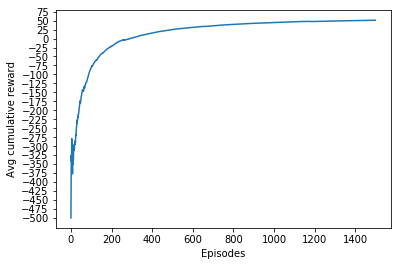

In [6]:
# Visualize learning evolution
plt.plot(cum_avg_reward_lst)
plt.ylabel('Avg cumulative reward')
plt.yticks(np.arange(-500, 100, step=25))
plt.xlabel('Episodes')
plt.show()

In [9]:
# Test rQ-learning
total_reward = 0
n_episodes = 20
n_steps = 50

env = gym.make('PutBallInBoxEnvRandom20x20-v0')
for i_episode in range(n_episodes):
    print('Episode: ' + str(i_episode+1))
    s,_,_,_ = env.reset()
    r_s = state_to_r_state(s)
    r_s = tuple(r_s)
    for t in range(n_steps):
        #env.render()
        r_a = np.argmax(Q[r_s])
        a_str = r_action_to_action(r_actions[r_a], s)
        a = actions.index(a_str)
        s1, r, done, _ = env.step(a)
        r_s1 = state_to_r_state(s1)
        r_s = tuple(r_s1)
        s = s1
        total_reward += r
        if done:
            print("Reached the goal after {} timesteps".format(t+1))
            break
        time.sleep(0.5)
    print(total_reward/(i_episode + 1))

Episode: 1
-50.0
Episode: 2
-50.0
Episode: 3
-50.0
Episode: 4
Reached the goal after 12 timesteps
-15.25
Episode: 5
Reached the goal after 21 timesteps
3.8
Episode: 6
-5.166666666666667
Episode: 7
-11.571428571428571
Episode: 8
-16.375
Episode: 9
-20.11111111111111
Episode: 10
-23.1
Episode: 11
-25.545454545454547
Episode: 12
Reached the goal after 23 timesteps
-16.916666666666668
Episode: 13
Reached the goal after 14 timesteps
-8.923076923076923
Episode: 14
Reached the goal after 10 timesteps
-1.7857142857142858
Episode: 15
Reached the goal after 16 timesteps
4.0
Episode: 16
Reached the goal after 12 timesteps
9.3125
Episode: 17
5.823529411764706
Episode: 18
2.7222222222222223
Episode: 19
-0.05263157894736842
Episode: 20
-2.55
